In [ ]:
# 한글 설치
!sudo apt-get install -y fonts-nanum

!sudo fc-cache -fv

!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (6,150 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126109 files and dire

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.metrics import silhouette_score
import pandas as pd
import warnings
import re
from sklearn.metrics import pairwise_distances_argmin_min
import seaborn as sns

In [ ]:
plt.rc('font', family='NanumBarunGothic')

##데이터 전처리 및 병합

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")

In [ ]:
!pip install openpyxl

(1) 고령자 인구 & 노인 자살률

In [ ]:
df_raw =pd.read_excel("/content/drive/MyDrive/코랩/데이터마이닝/자살률(구별).xlsx")

# 전국 평균 자살률 정보 (단위: 명 / 10만명)
national_elderly_suicide_rate = 40.6
national_total_suicide_rate = 27.3

# 자치구별 자살률 데이터 불러오기 및 0행 제거
df = df_raw.iloc[1:].copy()  # 0행(소계) 제거

# 필요한 컬럼 추출 및 이름 변경
df = df[['자치구별', '자살률 (10만명당 명)']]
df.rename(columns={
    '자치구별': '자치구',
    '자살률 (10만명당 명)': '전체 자살률'
}, inplace=True)

# 3️자치구별 추정 노인 자살률 열 추가
df['추정 노인 자살률'] = df['전체 자살률'] * (national_elderly_suicide_rate / national_total_suicide_rate)

df = df[['자치구', '추정 노인 자살률']]

df

,자치구,추정 노인 자살률
1,종로구,36.435897
2,중구,43.723077
3,용산구,32.271795
4,성동구,34.353846
5,광진구,40.451282
6,동대문구,37.179487
7,중랑구,40.600000
8,성북구,33.164103
9,강북구,37.030769
10,도봉구,41.194872


(2) 독거 노인 인구

In [ ]:
lonely_df = pd.read_excel("/content/drive/MyDrive/코랩/데이터마이닝/팀플/data/독거 노인 인구.xlsx")

lonely_cleaned = lonely_df.iloc[1:].copy()

# 필요한 열 선택 및 열 이름 변경
lonely_cleaned = lonely_cleaned[['자치구', '소계', '국민기초생활보장 수급권자', '저소득노인']]
lonely_cleaned.columns = ['자치구', '독거노인 합계', '기초수급자 합계', '저소득노인 합계']

# 수치형으로 변환
lonely_cleaned[['독거노인 합계', '기초수급자 합계', '저소득노인 합계']] = lonely_cleaned[
    ['독거노인 합계', '기초수급자 합계', '저소득노인 합계']
].apply(pd.to_numeric, errors='coerce')

# df에 중복 열이 있을 경우 삭제
for col in ['독거노인 합계', '기초수급자 합계', '저소득노인 합계']:
    if col in df.columns:
        df = df.drop(columns=[col])

# 자치구 기준으로 병합
df = pd.merge(df, lonely_cleaned, on='자치구', how='left')

df

,자치구,추정 노인 자살률,독거노인 합계,기초수급자 합계,저소득노인 합계
0,종로구,36.435897,11178,2231,403
1,중구,43.723077,7987,2553,324
2,용산구,32.271795,10498,3029,96
3,성동구,34.353846,12141,3536,239
4,광진구,40.451282,13657,3875,981
5,동대문구,37.179487,18625,5993,446
6,중랑구,40.600000,22438,8428,391
7,성북구,33.164103,19763,7495,994
8,강북구,37.030769,20398,7635,767
9,도봉구,41.194872,17136,4964,1133


(3) 노인 의료복지 시설

In [ ]:
medical_df = pd.read_excel("/content/drive/MyDrive/코랩/데이터마이닝/팀플/data/서울시 노인의료복지시설현황.xlsx")

facilities = medical_df.iloc[3:].copy()

# 자치구 열 이름 지정 및 정리
facilities = facilities.rename(columns={'Unnamed: 1': '자치구'})
facilities['자치구'] = facilities['자치구'].astype(str).str.strip()

facilities = facilities[facilities['자치구'].str.contains("구", na=False)]

# 자치구별 시설 수 계산
facility_counts = facilities['자치구'].value_counts().reset_index()
facility_counts.columns = ['자치구', '노인의료복지시설 수']

df['자치구'] = df['자치구'].astype(str).str.strip()

# 병합 전 동일 열이 있으면 제거
if '노인의료복지시설 수' in df.columns:
    df = df.drop(columns=['노인의료복지시설 수'])

# 병합
df = pd.merge(df, facility_counts, on='자치구', how='left')

# 9. NaN → 0 처리
df['노인의료복지시설 수'] = df['노인의료복지시설 수'].fillna(0).astype(int)

df

,자치구,추정 노인 자살률,독거노인 합계,기초수급자 합계,저소득노인 합계,노인의료복지시설 수
0,종로구,36.435897,11178,2231,403,8
1,중구,43.723077,7987,2553,324,2
2,용산구,32.271795,10498,3029,96,2
3,성동구,34.353846,12141,3536,239,4
4,광진구,40.451282,13657,3875,981,8
5,동대문구,37.179487,18625,5993,446,7
6,중랑구,40.600000,22438,8428,391,11
7,성북구,33.164103,19763,7495,994,19
8,강북구,37.030769,20398,7635,767,10
9,도봉구,41.194872,17136,4964,1133,21


(4) 재가노인 복지시설

In [ ]:
homecare_df = pd.read_excel("/content/drive/MyDrive/코랩/데이터마이닝/팀플/data/서울시 재가노인 복지시설 현황.xlsx")

# 자치구와 시설 수(합계) 열만 추출
homecare_facilities = homecare_df[['자치구', '합계']].copy()

homecare_facilities['자치구'] = homecare_facilities['자치구'].astype(str).str.strip()

homecare_facilities['합계'] = pd.to_numeric(homecare_facilities['합계'], errors='coerce')

# 열 이름 변경
homecare_facilities = homecare_facilities.rename(columns={'합계': '재가노인 복지시설 수(개소)'})

df['자치구'] = df['자치구'].astype(str).str.strip()

# 병합 전 동일 열이 있으면 제거
if '재가노인 복지시설 수(개소)' in df.columns:
    df = df.drop(columns=['재가노인 복지시설 수(개소)'])

df = pd.merge(df, homecare_facilities, on='자치구', how='left')

# NaN 값은 0으로 처리
df['재가노인 복지시설 수(개소)'] = df['재가노인 복지시설 수(개소)'].fillna(0).astype(int)

# 불필요한 열 제거
if '재가노인 복지시설 수' in df.columns:
    df = df.drop(columns=['재가노인 복지시설 수'])

# 열 이름 변경
df = df.rename(columns={'재가노인 복지시설 수(개소)': '재가노인복지시설 수'})
df

,자치구,추정 노인 자살률,독거노인 합계,기초수급자 합계,저소득노인 합계,노인의료복지시설 수,재가노인복지시설 수
0,종로구,36.435897,11178,2231,403,8,27
1,중구,43.723077,7987,2553,324,2,34
2,용산구,32.271795,10498,3029,96,2,21
3,성동구,34.353846,12141,3536,239,4,43
4,광진구,40.451282,13657,3875,981,8,55
5,동대문구,37.179487,18625,5993,446,7,87
6,중랑구,40.600000,22438,8428,391,11,169
7,성북구,33.164103,19763,7495,994,19,92
8,강북구,37.030769,20398,7635,767,10,109
9,도봉구,41.194872,17136,4964,1133,21,122


(5) 여가복지시설

In [ ]:
leisure_df = pd.read_excel("/content/drive/MyDrive/코랩/데이터마이닝/팀플/data/서울시 노인여가 복지시설 현황 .xlsx")

# 필요한 열만 추출하고 이름 정리
leisure_df = leisure_df[['자치구', '노인복지관 수', '복지관종사자 수', '경로당 수', '노인교실 수']]
leisure_df.rename(columns={
    '노인복지관 수': '복지관 수',
    '복지관종사자 수': '복지관종사자 수',
    '경로당 수': '경로당 수',
    '노인교실 수': '노인교실 수'
}, inplace=True)

# df에 네 가지 열을 자치구 기준으로 붙이기
for col in ['복지관 수', '복지관종사자 수', '경로당 수', '노인교실 수']:
    df[col] = df['자치구'].map(leisure_df.set_index('자치구')[col])

df

,자치구,추정 노인 자살률,독거노인 합계,기초수급자 합계,저소득노인 합계,노인의료복지시설 수,재가노인복지시설 수,복지관 수,복지관종사자 수,경로당 수,노인교실 수
0,종로구,36.435897,11178,2231,403,8,27,3,169,62,9
1,중구,43.723077,7987,2553,324,2,34,2,71,50,3
2,용산구,32.271795,10498,3029,96,2,21,2,84,89,20
3,성동구,34.353846,12141,3536,239,4,43,5,104,164,12
4,광진구,40.451282,13657,3875,981,8,55,1,63,97,8
5,동대문구,37.179487,18625,5993,446,7,87,1,114,136,16
6,중랑구,40.600000,22438,8428,391,11,169,5,128,131,11
7,성북구,33.164103,19763,7495,994,19,92,6,112,180,7
8,강북구,37.030769,20398,7635,767,10,109,1,36,100,18
9,도봉구,41.194872,17136,4964,1133,21,122,5,102,136,4


(6) 요양 보호사 수

In [ ]:
caregiver_df = pd.read_csv("/content/drive/MyDrive/코랩/데이터마이닝/팀플/data/서울시 요양보호사 남녀별 자격 현황정보.csv", encoding='cp949')

gu_names = caregiver_df['자치구명'].unique()
print("자치구명 목록:")
for gu in gu_names:
    print(gu)

자치구명 목록:
타시도
강동구
강북구
서대문구
마포구
강남구
광진구
은평구
동작구
중구
종로구
도봉구
양천구
금천구
구로구
영등포구
성동구
관악구
강서구
동대문구
송파구
성북구
용산구
노원구
서초구


중랑구 데이터 결측 확인

In [ ]:
caregiver_by_gu = caregiver_df.groupby('자치구명')['인원(명)'].sum().reset_index()
caregiver_by_gu.rename(columns={'자치구명': '자치구', '인원(명)': '요양보호사 수'}, inplace=True)

# 기존 df에 자치구 기준으로 병합
df = pd.merge(df, caregiver_by_gu, on='자치구', how='left')

df

,자치구,추정 노인 자살률,독거노인 합계,기초수급자 합계,저소득노인 합계,노인의료복지시설 수,재가노인복지시설 수,복지관 수,복지관종사자 수,경로당 수,노인교실 수,요양보호사 수
0,종로구,36.435897,11178,2231,403,8,27,3,169,62,9,4986.0
1,중구,43.723077,7987,2553,324,2,34,2,71,50,3,4081.0
2,용산구,32.271795,10498,3029,96,2,21,2,84,89,20,6151.0
3,성동구,34.353846,12141,3536,239,4,43,5,104,164,12,10017.0
4,광진구,40.451282,13657,3875,981,8,55,1,63,97,8,15103.0
5,동대문구,37.179487,18625,5993,446,7,87,1,114,136,16,14132.0
6,중랑구,40.600000,22438,8428,391,11,169,5,128,131,11,NaN
7,성북구,33.164103,19763,7495,994,19,92,6,112,180,7,18916.0
8,강북구,37.030769,20398,7635,767,10,109,1,36,100,18,16496.0
9,도봉구,41.194872,17136,4964,1133,21,122,5,102,136,4,18300.0


In [ ]:
# 요양보호사 수의 평균으로 중랑구 결측치 채우기
mean_caregiver = df['요양보호사 수'].mean()
df.loc[df['자치구'] == '중랑구', '요양보호사 수'] = mean_caregiver

(7) 정류장 & 평균 노선 수

In [ ]:
bus_stop_df = pd.read_excel("/content/drive/MyDrive/코랩/데이터마이닝/팀플/data/서울시 정류소현황(2019~2023년).xlsx")

# 자치구별로 정류장 수 (고유 ARS-ID 개수)와 평균 노선 수 계산
bus_stats = bus_stop_df.groupby('행정구명').agg(
    정류장수=('ARS-ID', 'nunique'),
    평균노선수=('노선수', 'mean')
).reset_index()

# 열 이름 정리
bus_stats.rename(columns={'행정구명': '자치구'}, inplace=True)


# 기존 df에 병합
df = pd.merge(df, bus_stats, on='자치구', how='left')

df

,자치구,추정 노인 자살률,독거노인 합계,기초수급자 합계,저소득노인 합계,노인의료복지시설 수,재가노인복지시설 수,복지관 수,복지관종사자 수,경로당 수,노인교실 수,요양보호사 수,정류장수,평균노선수
0,종로구,36.435897,11178,2231,403,8,27,3,169,62,9,4986.00,386,3.481865
1,중구,43.723077,7987,2553,324,2,34,2,71,50,3,4081.00,229,5.454148
2,용산구,32.271795,10498,3029,96,2,21,2,84,89,20,6151.00,351,3.048433
3,성동구,34.353846,12141,3536,239,4,43,5,104,164,12,10017.00,447,2.118568
4,광진구,40.451282,13657,3875,981,8,55,1,63,97,8,15103.00,294,3.414966
5,동대문구,37.179487,18625,5993,446,7,87,1,114,136,16,14132.00,322,4.593168
6,중랑구,40.600000,22438,8428,391,11,169,5,128,131,11,16079.75,380,4.368421
7,성북구,33.164103,19763,7495,994,19,92,6,112,180,7,18916.00,604,2.657285
8,강북구,37.030769,20398,7635,767,10,109,1,36,100,18,16496.00,451,2.689579
9,도봉구,41.194872,17136,4964,1133,21,122,5,102,136,4,18300.00,391,2.826087


(8) 노인 보행 교통사고

In [ ]:
traffic_data = pd.read_excel('/content/drive/MyDrive/코랩/데이터마이닝/팀플/data/서울시 노인 교통사고 현황 통계.xlsx', sheet_name='데이터')

# 필요한 열만 선택
traffic_data_selected = traffic_data[['자치구', '노인 보행 교통사고']]

df = df.merge(traffic_data_selected, on='자치구', how='left')

df

,자치구,추정 노인 자살률,독거노인 합계,기초수급자 합계,저소득노인 합계,노인의료복지시설 수,재가노인복지시설 수,복지관 수,복지관종사자 수,경로당 수,노인교실 수,요양보호사 수,정류장수,평균노선수,노인 보행 교통사고
0,종로구,36.435897,11178,2231,403,8,27,3,169,62,9,4986.00,386,3.481865,67
1,중구,43.723077,7987,2553,324,2,34,2,71,50,3,4081.00,229,5.454148,60
2,용산구,32.271795,10498,3029,96,2,21,2,84,89,20,6151.00,351,3.048433,31
3,성동구,34.353846,12141,3536,239,4,43,5,104,164,12,10017.00,447,2.118568,52
4,광진구,40.451282,13657,3875,981,8,55,1,63,97,8,15103.00,294,3.414966,23
5,동대문구,37.179487,18625,5993,446,7,87,1,114,136,16,14132.00,322,4.593168,155
6,중랑구,40.600000,22438,8428,391,11,169,5,128,131,11,16079.75,380,4.368421,122
7,성북구,33.164103,19763,7495,994,19,92,6,112,180,7,18916.00,604,2.657285,97
8,강북구,37.030769,20398,7635,767,10,109,1,36,100,18,16496.00,451,2.689579,80
9,도봉구,41.194872,17136,4964,1133,21,122,5,102,136,4,18300.00,391,2.826087,61


In [ ]:
# df를 엑셀 파일로 저장
output_path = "/content/drive/MyDrive/코랩/데이터마이닝/팀플/전처리데이터.xlsx"
df.to_excel(output_path, index=False)

print(f"엑셀 파일이 저장되었습니다: {output_path}")

엑셀 파일이 저장되었습니다: /content/drive/MyDrive/코랩/데이터마이닝/팀플/전처리데이터.xlsx


In [ ]:
# 기존 전처리 데이터
df = pd.read_excel("/content/drive/MyDrive/코랩/데이터마이닝/팀플/전처리데이터.xlsx")

# 고령자 등록 인구 데이터
elderly_df = pd.read_excel("/content/drive/MyDrive/코랩/데이터마이닝/팀플/data/고령자 등록인구.xlsx")

# 자치구 기준으로 병합
merged_df = df.merge(elderly_df, on='자치구', how='left')

# 결과 파일로 저장
merged_df.to_excel("/content/drive/MyDrive/코랩/데이터마이닝/팀플/전처리데이터_노인인구포함.xlsx", index=False)

print("✅ 병합 완료: '전처리데이터_고령자포함.xlsx' 파일이 생성되었습니다.")

✅ 병합 완료: '전처리데이터_고령자포함.xlsx' 파일이 생성되었습니다.


## EDA

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/코랩/데이터마이닝/팀플/전처리데이터_노인인구포함.xlsx", sheet_name="Sheet1")

# 데이터 크기 및 열 이름 확인
print(" 데이터 크기:", df.shape)
print("\n 열 이름:")
print(df.columns)

# 데이터 샘플 확인
print("\n 데이터 샘플:")
print(df.head())

# 데이터 타입, 결측치 정보 확인
print("\n 데이터 타입 및 결측치:")
print(df.info())
print("\n 결측치 개수:")
print(df.isnull().sum())

 데이터 크기: (25, 16)

 열 이름:
Index(['자치구', '추정 노인 자살률', '독거노인 합계', '기초수급자 합계', '저소득노인 합계', '노인의료복지시설 수',
       '재가노인복지시설 수', '복지관 수', '복지관종사자 수', '경로당 수', '노인교실 수', '요양보호사 수', '정류장수',
       '평균노선수', '노인 보행 교통사고', '노인인구 수'],
      dtype='object')

 데이터 샘플:
   자치구  추정 노인 자살률  독거노인 합계  기초수급자 합계  저소득노인 합계  노인의료복지시설 수  재가노인복지시설 수  복지관 수  \
0  종로구  36.435897    11178      2231       403           8          27      3   
1   중구  43.723077     7987      2553       324           2          34      2   
2  용산구  32.271795    10498      3029        96           2          21      2   
3  성동구  34.353846    12141      3536       239           4          43      5   
4  광진구  40.451282    13657      3875       981           8          55      1   

   복지관종사자 수  경로당 수  노인교실 수  요양보호사 수  정류장수     평균노선수  노인 보행 교통사고  노인인구 수  
0       169     62       9   4986.0   386  3.481865          67   28764  
1        71     50       3   4081.0   229  5.454148          60   25920  
2        84     89      20   6151.0 

In [ ]:
# 수치형 변수의 기초 통계량
print("\n 수치형 변수 기초 통계량:")
print(df.describe())


 수치형 변수 기초 통계량:
       추정 노인 자살률       독거노인 합계      기초수급자 합계     저소득노인 합계  노인의료복지시설 수  \
count  25.000000     25.000000     25.000000    25.000000   25.000000   
mean   35.032000  17930.040000   5171.000000   511.000000    9.600000   
std     4.956660   6274.943901   2463.148916   256.554413    5.597619   
min    24.835897   7987.000000   1514.000000    96.000000    2.000000   
25%    32.271795  13657.000000   3536.000000   329.000000    6.000000   
50%    34.353846  17825.000000   4799.000000   446.000000    9.000000   
75%    37.476923  20973.000000   7417.000000   642.000000   12.000000   
max    43.723077  36839.000000  10606.000000  1133.000000   21.000000   

       재가노인복지시설 수     복지관 수    복지관종사자 수       경로당 수     노인교실 수      요양보호사 수  \
count   25.000000  25.00000   25.000000   25.000000  25.000000     25.00000   
mean    83.400000   3.52000  105.600000  139.600000  13.680000  16079.75000   
std     37.995614   1.71075   40.030197   45.807569   6.108191   6545.22643   
min     2

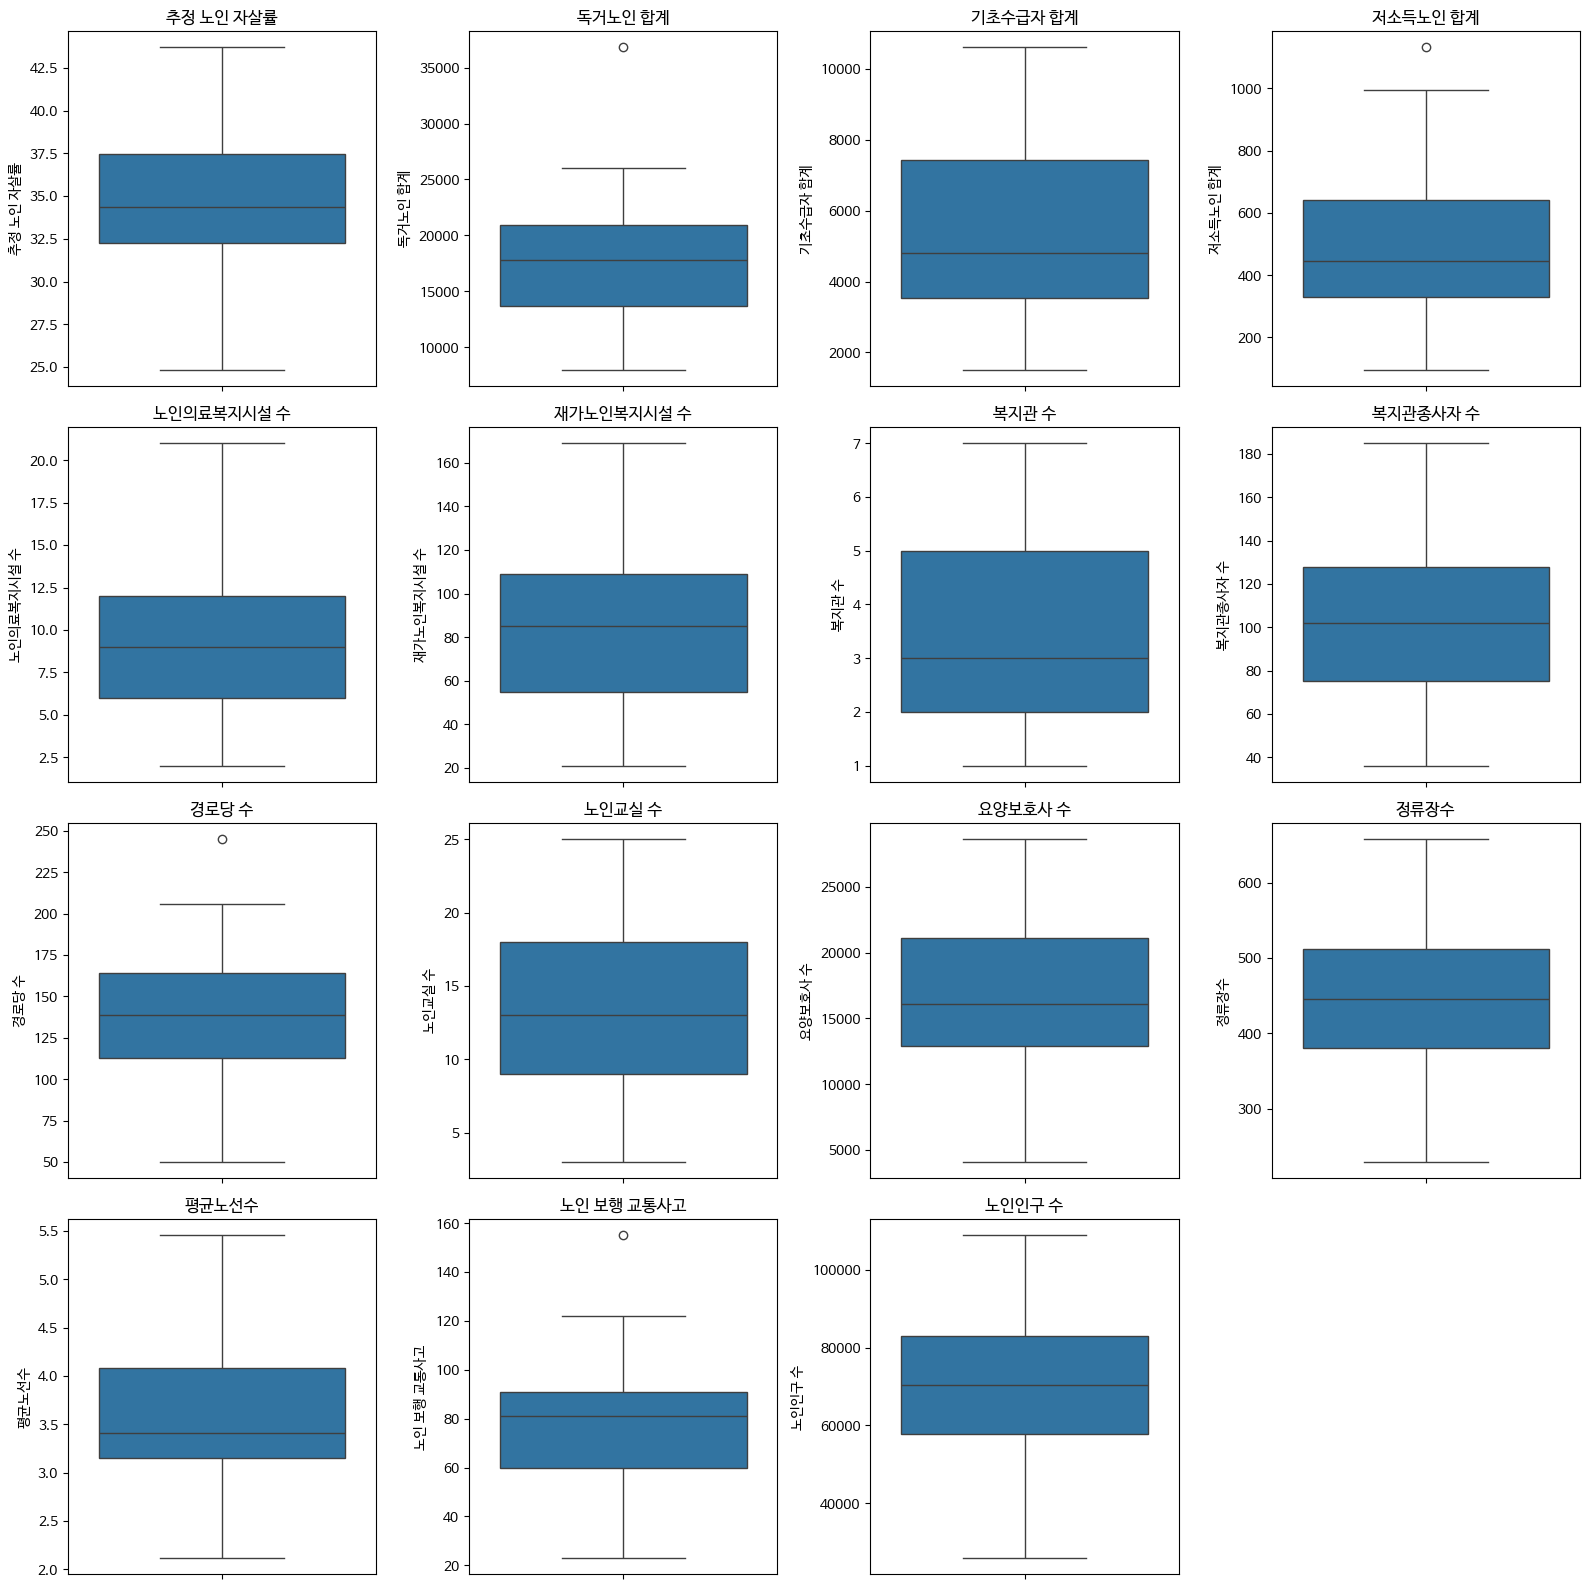

In [ ]:
numeric_cols = df.select_dtypes(include='number').columns.tolist()
if '추정노인자살률' in numeric_cols:
    numeric_cols.remove('추정노인자살률')

# 그래프 구성 (한 행에 4개씩)
cols_per_row = 4
num_cols = len(numeric_cols)
num_rows = (num_cols + cols_per_row - 1) // cols_per_row

plt.figure(figsize=(cols_per_row * 4, num_rows * 4))

for idx, col in enumerate(numeric_cols):
    plt.subplot(num_rows, cols_per_row, idx + 1)
    sns.boxplot(y=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

## k-means clustering

In [ ]:
!pip install geopandas

##PCA로 차원 축소 후 클러스터링

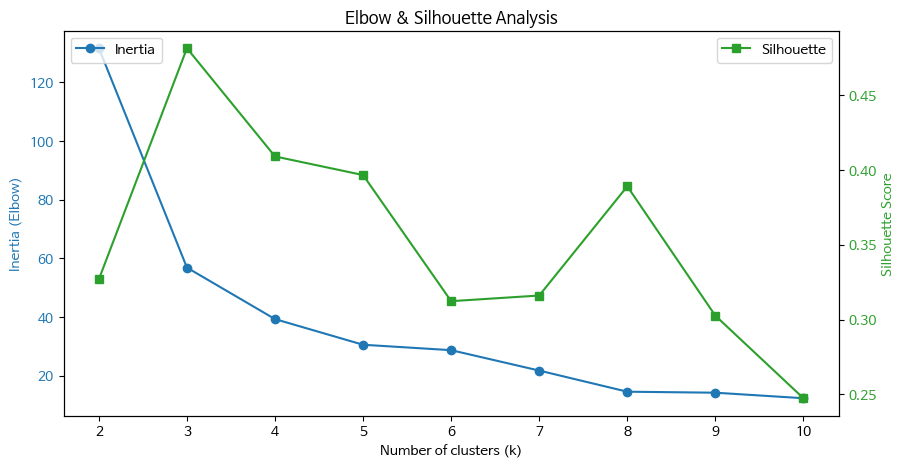

In [ ]:
# 자치구명 정리 함수
def clean_gu(name):
    return re.sub(r'[^가-힣]', '', str(name)).replace('서울특별시', '').strip()

# 데이터 불러오기
df = pd.read_excel("/content/drive/MyDrive/코랩/데이터마이닝/팀플/전처리데이터_노인인구포함.xlsx", sheet_name="Sheet1")
df["자치구"] = df["자치구"].apply(clean_gu)

# 1인당으로 환산할 변수 목록
per_capita_vars = [
    "독거노인 합계", "기초수급자 합계", "저소득노인 합계",
    "노인의료복지시설 수", "재가노인복지시설 수", "복지관 수",
    "복지관종사자 수", "노인교실 수", "정류장수"
]

for var in per_capita_vars:
    df[f"1인당 {var}"] = df[var] / df["노인인구 수"]
df = df.drop(columns=per_capita_vars)

# 클러스터링 대상 변수
features_for_clustering = df.columns.drop("자치구")
X_filtered = df[features_for_clustering]
scaler = StandardScaler()
X_scaled_filtered = scaler.fit_transform(X_filtered)

# PCA로 2D로 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_filtered)

# Elbow & Silhouette 계산
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pca, labels))

# 시각화
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:blue'
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia (Elbow)', color=color)
ax1.plot(K_range, inertias, marker='o', color=color, label="Inertia")
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(K_range, silhouette_scores, marker='s', color=color, label="Silhouette")
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc="upper right")

plt.title("Elbow & Silhouette Analysis")
plt.show()


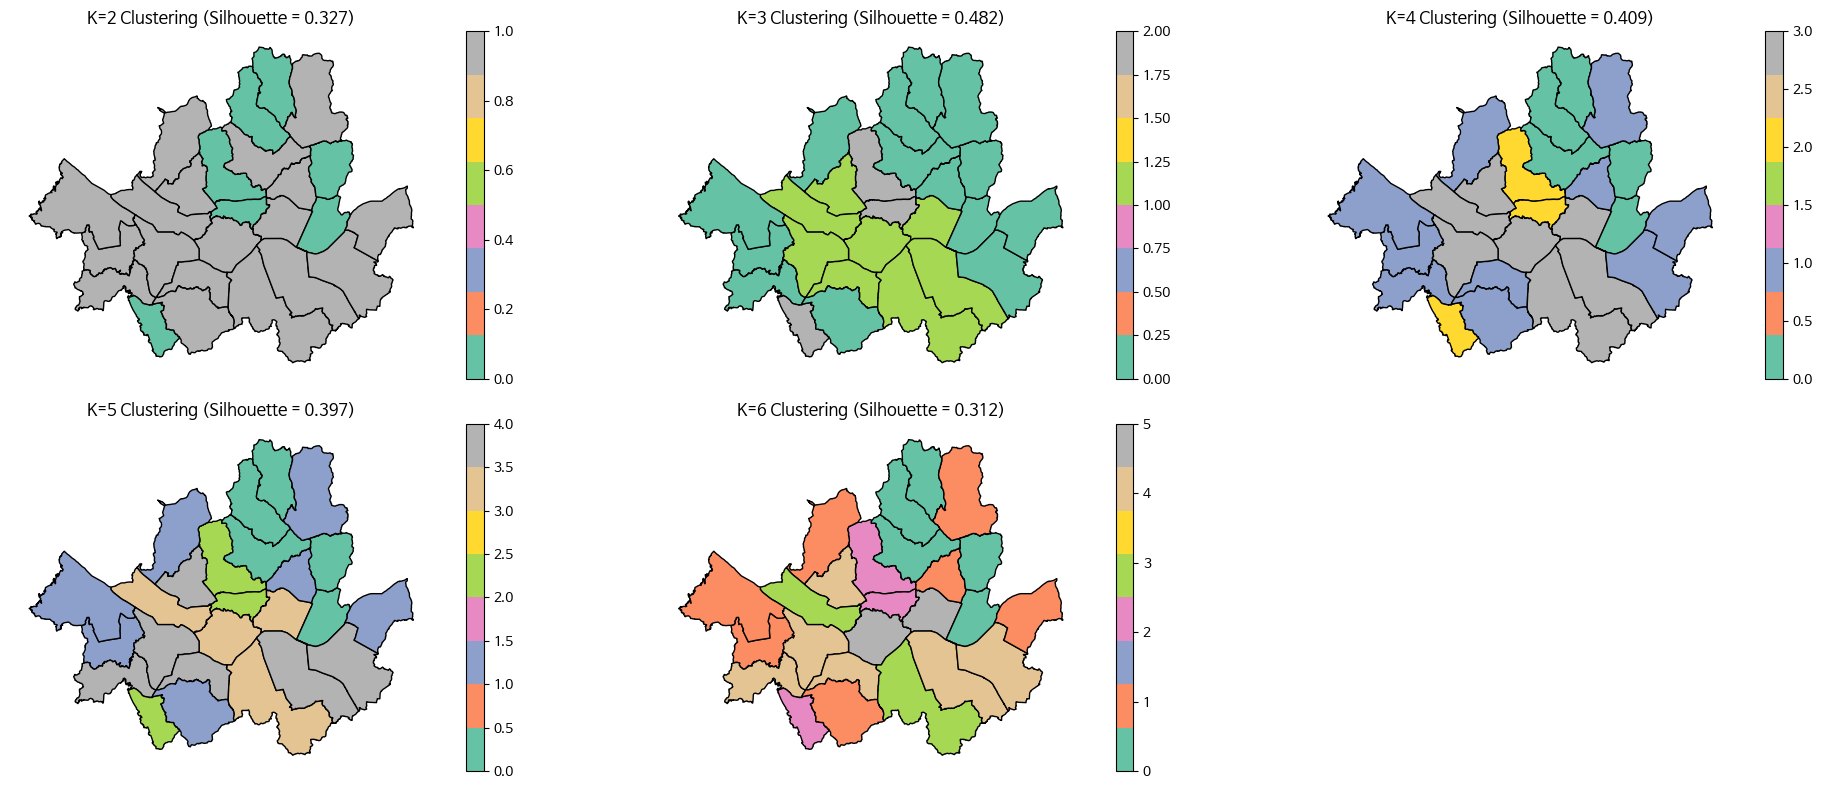

📊 실루엣 계수 (PCA 2D 축소 후):
K=2: 0.327
K=3: 0.4816
K=4: 0.4092
K=5: 0.3967
K=6: 0.3123


In [ ]:
# 클러스터링 & 지도 시각화
silhouette_scores_pca = {}
cluster_summaries_pca = {}

plt.figure(figsize=(20, 8))

for idx, k in enumerate(range(2, 7)):
    kmeans = KMeans(n_clusters=k, random_state=42)
    df[f"클러스터_PCA_{k}"] = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, df[f"클러스터_PCA_{k}"])
    silhouette_scores_pca[k] = round(score, 4)

    summary = df.groupby(f"클러스터_PCA_{k}")[features_for_clustering].mean()
    cluster_summaries_pca[k] = summary

    # 지도 시각화
    shp_path = "/content/drive/MyDrive/코랩/데이터마이닝/팀플/data/LARD_ADM_SECT_SGG_11_202505.shp"
    gdf = gpd.read_file(shp_path)
    gdf = gdf.rename(columns={"SGG_NM": "자치구"})
    gdf["자치구"] = gdf["자치구"].apply(clean_gu)
    gdf = gdf.to_crs(epsg=4326)

    merged = gdf.merge(df, on="자치구", how="left")
    plt.subplot(2, 3, idx + 1)
    merged.plot(column=f"클러스터_PCA_{k}", cmap="Set2", legend=True, edgecolor="black", ax=plt.gca())
    plt.title(f"K={k} Clustering (Silhouette = {silhouette_scores_pca[k]:.3f})", fontsize=12)
    plt.axis("off")

plt.tight_layout()
plt.show()

# 결과 출력
print("📊 실루엣 계수 (PCA 2D 축소 후):")
for k, score in silhouette_scores_pca.items():
    print(f"K={k}: {score}")

In [ ]:
cols_to_use = [
    '추정 노인 자살률', '경로당 수', '요양보호사 수', '평균노선수', '노인 보행 교통사고',
    '노인인구 수', '1인당 독거노인 합계', '1인당 기초수급자 합계', '1인당 저소득노인 합계',
    '1인당 노인의료복지시설 수', '1인당 재가노인복지시설 수', '1인당 복지관 수',
    '1인당 복지관종사자 수', '1인당 노인교실 수', '1인당 정류장수'
]

cluster_summary = df.groupby('클러스터_PCA_3')[cols_to_use].mean()
cluster_summary

,추정 노인 자살률,경로당 수,요양보호사 수,평균노선수,노인 보행 교통사고,노인인구 수,1인당 독거노인 합계,1인당 기초수급자 합계,1인당 저소득노인 합계,1인당 노인의료복지시설 수,1인당 재가노인복지시설 수,1인당 복지관 수,1인당 복지관종사자 수,1인당 노인교실 수,1인당 정류장수
클러스터_PCA_3,,,,,,,,,,,,,,,
0,36.159707,154.071429,20437.196429,3.609024,91.500,82014.500,0.261753,0.083290,0.008039,0.000157,0.001329,0.000040,0.001304,0.000178,0.005499
1,31.100641,143.500000,12142.000000,3.554277,61.375,61933.375,0.234724,0.054872,0.005394,0.000076,0.000939,0.000065,0.001525,0.000251,0.008220
2,40.252991,61.666667,6245.666667,4.089782,67.000,33342.000,0.322079,0.081704,0.013755,0.000221,0.001096,0.000090,0.004202,0.000194,0.010109


In [ ]:
print(df[['자치구', '클러스터_PCA_3']])

     자치구  클러스터_PCA_3
0    종로구           2
1     중구           2
2    용산구           1
3    성동구           1
4    광진구           0
5   동대문구           0
6    중랑구           0
7    성북구           0
8    강북구           0
9    도봉구           0
10   노원구           0
11   은평구           0
12  서대문구           1
13   마포구           1
14   양천구           0
15   강서구           0
16   구로구           0
17   금천구           2
18  영등포구           1
19   동작구           1
20   관악구           0
21   서초구           1
22   강남구           1
23   송파구           0
24   강동구           0


In [ ]:
cluster_summary

,추정 노인 자살률,경로당 수,요양보호사 수,평균노선수,노인 보행 교통사고,노인인구 수,1인당 독거노인 합계,1인당 기초수급자 합계,1인당 저소득노인 합계,1인당 노인의료복지시설 수,1인당 재가노인복지시설 수,1인당 복지관 수,1인당 복지관종사자 수,1인당 노인교실 수,1인당 정류장수
클러스터_PCA_3,,,,,,,,,,,,,,,
0,36.159707,154.071429,20437.196429,3.609024,91.500,82014.500,0.261753,0.083290,0.008039,0.000157,0.001329,0.000040,0.001304,0.000178,0.005499
1,31.100641,143.500000,12142.000000,3.554277,61.375,61933.375,0.234724,0.054872,0.005394,0.000076,0.000939,0.000065,0.001525,0.000251,0.008220
2,40.252991,61.666667,6245.666667,4.089782,67.000,33342.000,0.322079,0.081704,0.013755,0.000221,0.001096,0.000090,0.004202,0.000194,0.010109


In [ ]:
# 군집별 대표 자치구 찾기
representative_districts = {}

for cluster_num in df_cleaned['클러스터_PCA_3'].unique():
    # 해당 군집 데이터
    cluster_data = df_cleaned[df_cleaned['클러스터_PCA_3'] == cluster_num][cols_to_use]

    # 군집 중심 (평균값)
    cluster_center = cluster_data.mean().values.reshape(1, -1)

    # 각 자치구 데이터와 군집 중심 거리 계산
    indices, distances = pairwise_distances_argmin_min(cluster_data, cluster_center)

    # 대표 자치구: 중심값과 가장 가까운 자치구
    closest_gu = df_cleaned[df_cleaned['클러스터_PCA_3'] == cluster_num].iloc[indices[0]]['자치구']
    representative_districts[cluster_num] = closest_gu

print("\nCluster별 대표 자치구:")
for cluster_num, gu_name in representative_districts.items():
    print(f"Cluster {cluster_num}: {gu_name}")


Cluster별 대표 자치구:
Cluster 2: 종로구
Cluster 1: 용산구
Cluster 0: 광진구


<ipython-input-40-a241fddcbb62>:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = rep_row.geometry.centroid.iloc[0]
<ipython-input-40-a241fddcbb62>:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = rep_row.geometry.centroid.iloc[0]
<ipython-input-40-a241fddcbb62>:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = rep_row.geometry.centroid.iloc[0]


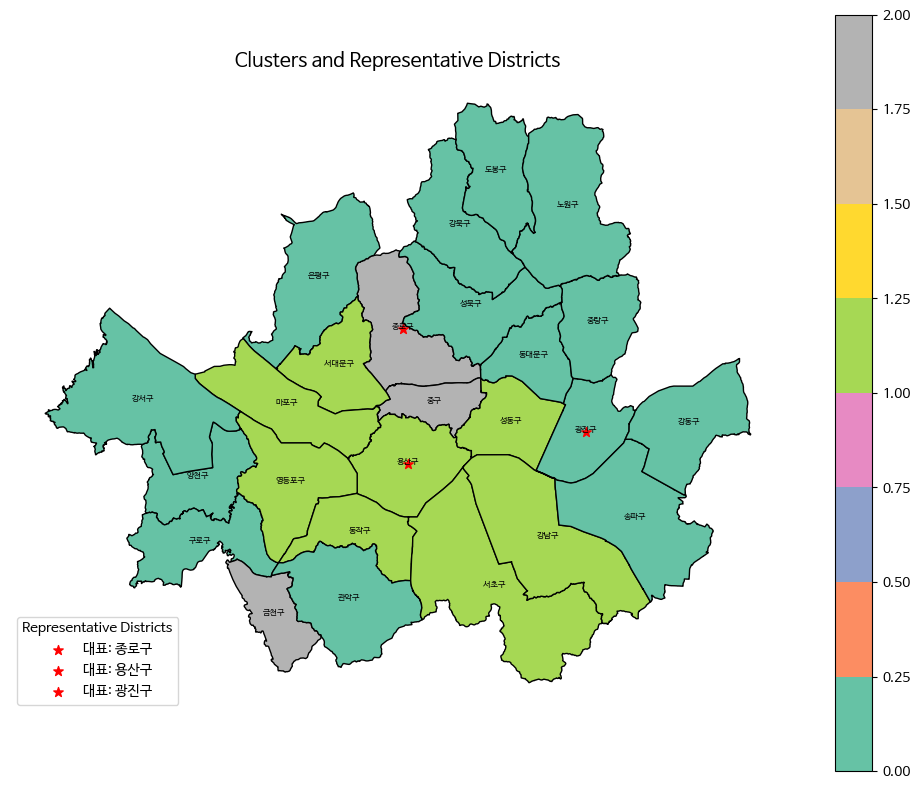

In [ ]:
shp_path = "/content/drive/MyDrive/코랩/데이터마이닝/팀플/data/LARD_ADM_SECT_SGG_11_202505.shp"
gdf = gpd.read_file(shp_path).rename(columns={"SGG_NM": "자치구"})
gdf["자치구"] = gdf["자치구"].apply(lambda x: x.replace("서울특별시", "").strip())
gdf = gdf.to_crs(epsg=4326)

# 군집 결과를 병합
merged = gdf.merge(df_cleaned[['자치구', '클러스터_PCA_3']], on='자치구', how='left')

# 지도 시각화
fig, ax = plt.subplots(figsize=(10, 8))
merged.plot(column='클러스터_PCA_3', cmap='Set2', legend=True, edgecolor='black', ax=ax)
ax.set_title("Clusters and Representative Districts", fontsize=14)

# 대표 자치구 위치만 강조 (별 표시)
for cluster_num, gu_name in representative_districts.items():
    rep_row = merged[merged['자치구'] == gu_name]
    centroid = rep_row.geometry.centroid.iloc[0]
    ax.scatter(centroid.x, centroid.y, color='red', s=50, marker='*', label=f'대표: {gu_name}')

# 🔹 각 자치구 이름을 **한글로** 표시
for idx, row in merged.iterrows():
    if pd.notnull(row['자치구']):
        centroid = row['geometry'].centroid
        ax.text(centroid.x, centroid.y, row['자치구'], ha='center', fontsize=6, color='black')

# 축 제거 및 범례 표시
ax.axis("off")
ax.legend(title='Representative Districts', loc='lower left')
plt.tight_layout()
plt.show()

# 클러스터별 우선순위 도출

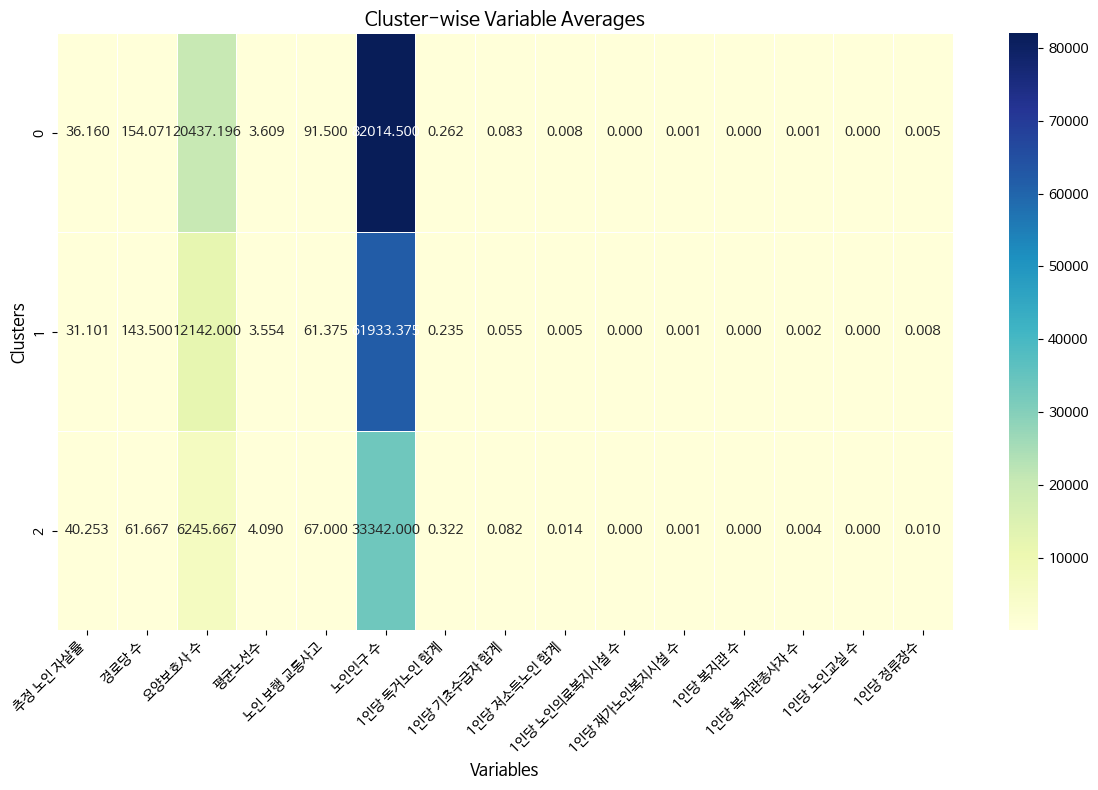

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_summary, annot=True, cmap='YlGnBu', fmt='.3f', linewidths=0.5)
plt.title('Cluster-wise Variable Averages', fontsize=14)
plt.xlabel('Variables', fontsize=12)
plt.ylabel('Clusters', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

클러스터 간 차이가 큰 변수들: ['경로당 수', '요양보호사 수', '노인 보행 교통사고', '노인인구 수']


<ipython-input-42-b22c1188b788>:20: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


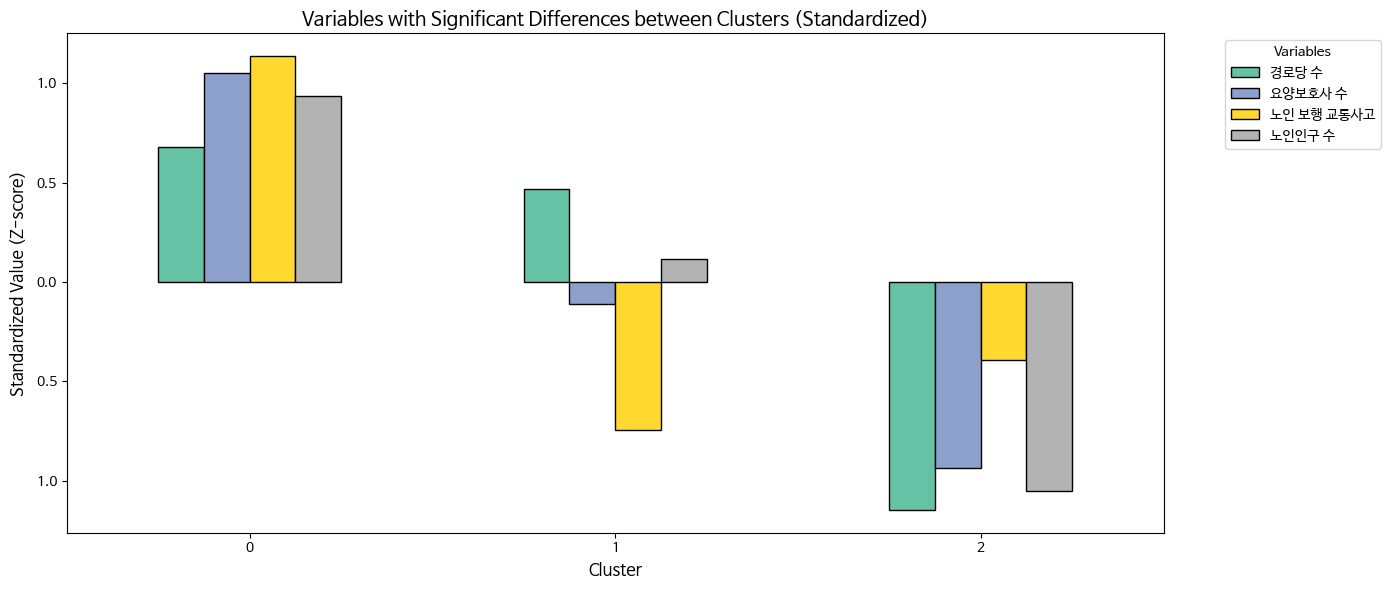

In [ ]:
diff = cluster_summary.max() - cluster_summary.min()

# 차이가 큰 변수만 선택 (예: 10 이상 차이)
important_vars = diff[diff > 10].index.tolist()
print("클러스터 간 차이가 큰 변수들:", important_vars)

# 차이가 큰 변수만 선택
cluster_summary_selected = cluster_summary[important_vars]

# Z-score로 변환 (표준화)
cluster_summary_standardized = (cluster_summary_selected - cluster_summary_selected.mean()) / cluster_summary_selected.std()

# 바 차트로 시각화
cluster_summary_standardized.plot(kind='bar', figsize=(14, 6), colormap='Set2', edgecolor='black')
plt.title('Variables with Significant Differences between Clusters (Standardized)', fontsize=14)
plt.ylabel('Standardized Value (Z-score)', fontsize=12)
plt.xlabel('Cluster', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Variables', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
#  카테고리별 변수 지정
infra_vars = ['1인당 복지관 수', '1인당 노인의료복지시설 수', '1인당 재가노인복지시설 수']
service_vars = ['요양보호사 수', '1인당 복지관종사자 수']
mobility_vars = ['1인당 정류장수', '평균노선수']
vulnerable_vars = ['1인당 독거노인 합계', '추정 노인 자살률']

#  Z-score로 표준화
standardized = (cluster_summary - cluster_summary.mean()) / cluster_summary.std()

# 가중치 설정
weights = {
    'infra': 0.15,
    'service': 0.25,
    'mobility': 0.15,
    'vulnerable': 0.45
}

# 카테고리별 평균 점수 (취약계층 역방향)
infra_score = standardized[infra_vars].mean(axis=1)
service_score = standardized[service_vars].mean(axis=1)
mobility_score = standardized[mobility_vars].mean(axis=1)
vulnerable_score = -standardized[vulnerable_vars].mean(axis=1)

# 가중합으로 최종 우선순위 점수 계산
priority_score = (
    infra_score * weights['infra'] +
    service_score * weights['service'] +
    mobility_score * weights['mobility'] +
    vulnerable_score * weights['vulnerable']
)

# 결과 데이터프레임
priority_df = pd.DataFrame({
    'Priority Score': priority_score
}, index=[0, 1, 2])

# 자치구-클러스터 매핑
gu_cluster_df = pd.DataFrame({
    '자치구': ['종로구', '중구', '용산구', '성동구', '광진구', '동대문구', '중랑구', '성북구', '강북구', '도봉구',
             '노원구', '은평구', '서대문구', '마포구', '양천구', '강서구', '구로구', '금천구', '영등포구', '동작구',
             '관악구', '서초구', '강남구', '송파구', '강동구'],
    '클러스터_PCA_3': [2, 2, 1, 1, 0, 0, 0, 0, 0, 0,
                    0, 0, 1, 1, 0, 0, 0, 2, 1, 1,
                    0, 1, 1, 0, 0]
})

# 클러스터별 자치구명 리스트로 정리
cluster_gu_dict = gu_cluster_df.groupby('클러스터_PCA_3')['자치구'].apply(list).to_dict()

# 우선순위 높은 순으로 정렬
priority_df_sorted = priority_df.sort_values('Priority Score', ascending=True)
priority_df_sorted['정책 도입 순위'] = range(1, len(priority_df_sorted) + 1)

# 각 순위별로 포함된 자치구 출력
print(" 클러스터별 최종 정책 도입 순위 및 자치구:")
for idx, row in priority_df_sorted.iterrows():
    cluster_id = idx
    gu_list = cluster_gu_dict.get(cluster_id, [])
    순위 = int(row['정책 도입 순위'])
    print(f"\n순위 {순위}위 (클러스터 {cluster_id}) - 정책 시급도: {row['Priority Score']:.3f}")
    print("포함된 자치구:", ', '.join(gu_list))

 클러스터별 최종 정책 도입 순위 및 자치구:

순위 1위 (클러스터 2) - 정책 시급도: -0.190
포함된 자치구: 종로구, 중구, 금천구

순위 2위 (클러스터 0) - 정책 시급도: -0.018
포함된 자치구: 광진구, 동대문구, 중랑구, 성북구, 강북구, 도봉구, 노원구, 은평구, 양천구, 강서구, 구로구, 관악구, 송파구, 강동구

순위 3위 (클러스터 1) - 정책 시급도: 0.208
포함된 자치구: 용산구, 성동구, 서대문구, 마포구, 영등포구, 동작구, 서초구, 강남구


In [ ]:
# 불필요한 클러스터링 열 제거
df_cleaned = df.drop(columns=['클러스터_PCA_2', '클러스터_PCA_4', '클러스터_PCA_5', '클러스터_PCA_6'])

# 결과 확인
print(df_cleaned.columns)

Index(['자치구', '추정 노인 자살률', '경로당 수', '요양보호사 수', '평균노선수', '노인 보행 교통사고', '노인인구 수',
       '1인당 독거노인 합계', '1인당 기초수급자 합계', '1인당 저소득노인 합계', '1인당 노인의료복지시설 수',
       '1인당 재가노인복지시설 수', '1인당 복지관 수', '1인당 복지관종사자 수', '1인당 노인교실 수', '1인당 정류장수',
       '클러스터_PCA_3'],
      dtype='object')


## Cluster 1에서의 세부 클러스터링

In [ ]:
df_cluster_1 = df_cleaned[df_cleaned['클러스터_PCA_3'] == 1].copy()

X_1 = df_cluster_1[cols_to_use]

# 표준화
scaler = StandardScaler()
X_1_scaled = scaler.fit_transform(X_1)

pca = PCA(n_components=2)
X_1_pca = pca.fit_transform(X_1_scaled)

ssd = []
silhouette_scores = {}

for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_1_pca)

    ssd.append(kmeans.inertia_)
    sil_score = silhouette_score(X_1_pca, labels)
    silhouette_scores[k] = sil_score

    df_cluster_1[f'하위클러스터_{k}'] = labels

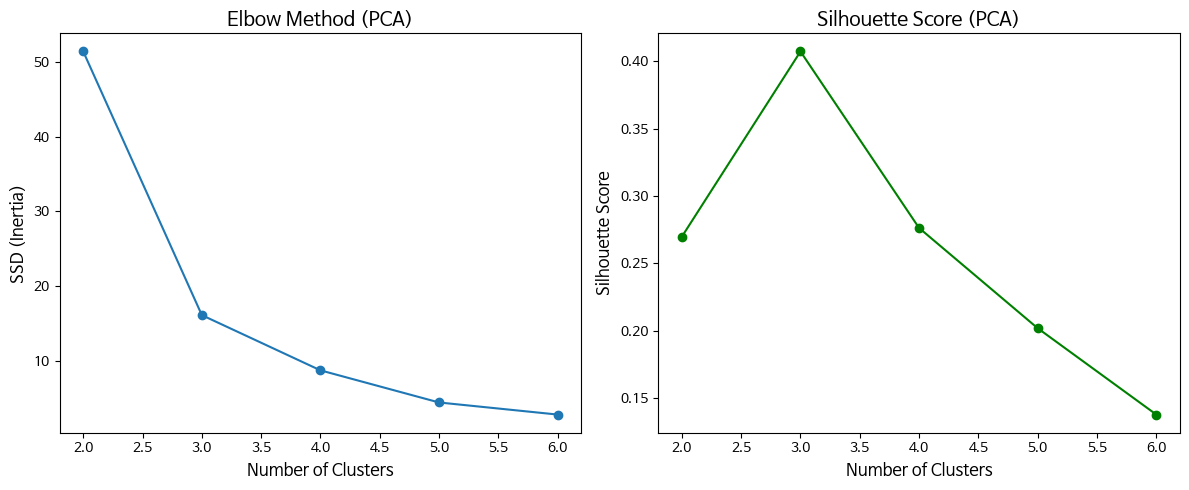

In [ ]:
plt.figure(figsize=(12, 5))

# Elbow
plt.subplot(1, 2, 1)
plt.plot(range(2, 7), ssd, 'o-')
plt.title('Elbow Method (PCA)', fontsize=14)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('SSD (Inertia)', fontsize=12)

# Silhouette score
plt.subplot(1, 2, 2)
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), 'o-', color='green')
plt.title('Silhouette Score (PCA)', fontsize=14)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
best_k_1 = max(silhouette_scores, key=silhouette_scores.get)
print(f" cluster 1의 최적 k: {best_k_1} (실루엣 계수: {silhouette_scores[best_k_1]:.3f})")

 cluster 1의 최적 k: 3 (실루엣 계수: 0.407)


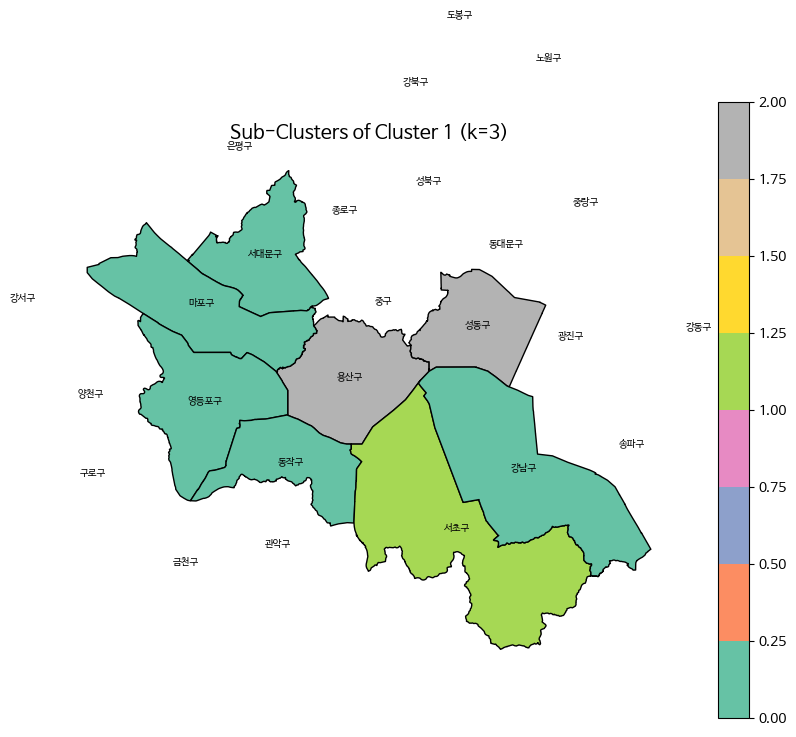

In [ ]:
shp_path = "/content/drive/MyDrive/코랩/데이터마이닝/팀플/data/LARD_ADM_SECT_SGG_11_202505.shp"
gdf = gpd.read_file(shp_path).rename(columns={"SGG_NM": "자치구"})
gdf["자치구"] = gdf["자치구"].apply(lambda x: x.replace("서울특별시", "").strip())
gdf = gdf.to_crs(epsg=4326)

# 병합 (자치구 이름으로)
merged_1 = gdf.merge(df_cluster_1[['자치구', f'하위클러스터_{best_k_1}']], on='자치구', how='left')

# 지도 시각화
fig, ax = plt.subplots(figsize=(10, 8))
merged_1.plot(column=f'하위클러스터_{best_k_1}', cmap='Set2', legend=True, edgecolor='black', ax=ax)
ax.set_title(f"Sub-Clusters of Cluster 1 (k={best_k_1})", fontsize=14)

# 한글 자치구 이름 표기
for idx, row in merged_1.iterrows():
    if pd.notnull(row['자치구']):
        centroid = row['geometry'].centroid
        ax.text(centroid.x, centroid.y, row['자치구'], ha='center', fontsize=7, color='black')

# 축 제거
ax.axis("off")
plt.show()


In [ ]:
# 최적의 k (예: 실루엣 계수가 가장 높은 k=3 선택)
best_k_1 = 3

# 선택된 서브 클러스터 열 이름
subcluster_col = f'하위클러스터_{best_k_1}'

# 서브 클러스터별 주요 변수 평균값 계산
subcluster_summary = df_cluster_1.groupby(subcluster_col)[cols_to_use].mean().round(3)

print(" Cluster 1의 서브 클러스터별 평균값:")
subcluster_summary

 Cluster 1의 서브 클러스터별 평균값:


,추정 노인 자살률,경로당 수,요양보호사 수,평균노선수,노인 보행 교통사고,노인인구 수,1인당 독거노인 합계,1인당 기초수급자 합계,1인당 저소득노인 합계,1인당 노인의료복지시설 수,1인당 재가노인복지시설 수,1인당 복지관 수,1인당 복지관종사자 수,1인당 노인교실 수,1인당 정류장수
하위클러스터_3,,,,,,,,,,,,,,,
0,31.469,151.2,14261.0,3.836,71.2,68119.4,0.240,0.051,0.007,0.0,0.001,0.0,0.001,0.0,0.008
1,24.836,139.0,9663.0,4.085,52.0,65661.0,0.167,0.036,0.003,0.0,0.001,0.0,0.002,0.0,0.010
2,33.313,126.5,8084.0,2.584,41.5,44604.5,0.255,0.074,0.004,0.0,0.001,0.0,0.002,0.0,0.009


In [ ]:
# 서브 클러스터가 저장된 컬럼 이름
subcluster_col = '하위클러스터_3'

# 서브 클러스터별 자치구 이름 출력
for cluster_label in df_cluster_1[subcluster_col].unique():
    gu_list = df_cluster_1[df_cluster_1[subcluster_col] == cluster_label]['자치구'].tolist()
    print(f" Sub-cluster {cluster_label}에 속하는 자치구:")
    print(gu_list)
    print()

 Sub-cluster 2에 속하는 자치구:
['용산구', '성동구']

 Sub-cluster 0에 속하는 자치구:
['서대문구', '마포구', '영등포구', '동작구', '강남구']

 Sub-cluster 1에 속하는 자치구:
['서초구']

